In [63]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from elon_musk_youtube_scraper import search_videos_advanced

In [45]:
# os.getcwd()
df = pd.read_csv('training_data_elon_musk.csv')
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
df.head(5)

,videoid,url,is_interview?_(verified),title,channeltitle,publishedat,channelid,description,thumbnails,livebroadcastcontent,publishtime,duration,viewcount,likecount,dislikecount,commentcount,probabilities
0,iNa62HS--Zg,https://www.youtube.com/watch?v=iNa62HS--Zg,1,Everything Elon Musk Said At Tesla's Autonomy Day,Farzad,2024-04-22T13:00:41Z,UCgbyN_o-Guwpyqfuuz3pyIw,The Robots Are Coming https://www.farzadmesbah...,https://i.ytimg.com/vi/iNa62HS--Zg/default.jpg,none,NaN,30.27,65812,2956.00,NaN,542.00,NaN
1,FPpPTp7FIHY,https://www.youtube.com/watch?v=FPpPTp7FIHY,1,Elon Musk: “10X Every 6 Months”,Farzad,2024-04-08T20:23:13Z,UCgbyN_o-Guwpyqfuuz3pyIw,Check out the original spaces on X:\nPart 1 - ...,https://i.ytimg.com/vi/FPpPTp7FIHY/default.jpg,none,NaN,32.48,183533,5722.00,NaN,601.00,NaN
2,7DPR9rzVCzk,https://www.youtube.com/watch?v=7DPR9rzVCzk,1,Elon Musk delivers SpaceX update following Sta...,VideoFromSpace,2024-04-08T14:00:16Z,UCVTomc35agH1SM6kCKzwW_g,SpaceX's Elon Musk talks about progress being ...,https://i.ytimg.com/vi/7DPR9rzVCzk/default.jpg,none,NaN,39.82,113812,1918.00,NaN,462.00,NaN
3,826YO436Gqw,https://www.youtube.com/watch?v=826YO436Gqw,1,Elon Musk Delivers Bombshell SpaceX Presentati...,Matt Pocius on Tesla Stock & Money,2024-04-06T23:52:59Z,UCF1iS7Bp9_hsQphNF6o8qwQ,Elon Musk delivers NEW 2024 SpaceX presentatio...,https://i.ytimg.com/vi/826YO436Gqw/default.jpg,none,NaN,44.03,162997,2794.00,NaN,583.00,NaN
4,OffMED-KXIs,https://www.youtube.com/watch?v=OffMED-KXIs,1,Elon Musk SpaceX Presentation Leaves Audience ...,Farzad,2024-04-06T22:01:41Z,UCgbyN_o-Guwpyqfuuz3pyIw,Check out the full presentation here on X - ht...,https://i.ytimg.com/vi/OffMED-KXIs/default.jpg,none,NaN,27.55,1688199,31118.00,NaN,6518.00,NaN


In [46]:
# Create training data
X = df['description']
y = df['is_interview?_(verified)']

In [47]:
interview_counts = df['is_interview?_(verified)'].value_counts()
print(interview_counts)

is_interview?_(verified)
0    31
1    19
Name: count, dtype: int64


In [48]:
# Train Word2Vec model on the training data
word2vec_model = Word2Vec(X, vector_size=100, window=5, min_count=1, workers=4)

# Create input features using the Word2Vec model
def get_text_features(text):
    words = text.split()
    features = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if features:
        return np.mean(features, axis=0)
    else:
        return np.zeros(100)

In [59]:
X_numerical = [get_text_features(text) for text in X]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_numerical, y, test_size=0.20, random_state=42)

# Train logistic regression model
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

# Get predicted probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]
print(y_pred_proba)

# Get predicted labels
y_pred = model.predict(X_test)

# Print classification report - for actual predicted labels
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix - for actual predicted labels
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Print ROC AUC curve - for probabilities
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.2f}")

[0.56157672 0.43334425 0.44460406 0.61066475 0.64744686 0.61066475
 0.54490989 0.60745166 0.64744686 0.49450228]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       0.29      1.00      0.44         2

    accuracy                           0.50        10
   macro avg       0.64      0.69      0.49        10
weighted avg       0.86      0.50      0.53        10

[[3 5]
 [0 2]]
AUC: 0.72


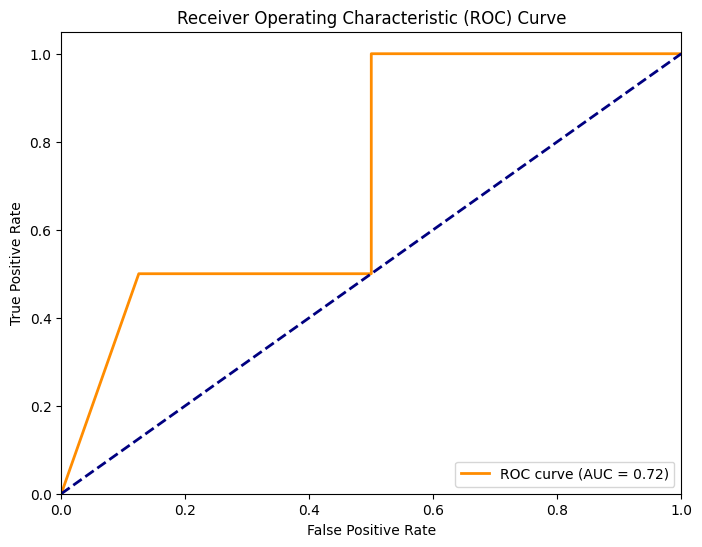

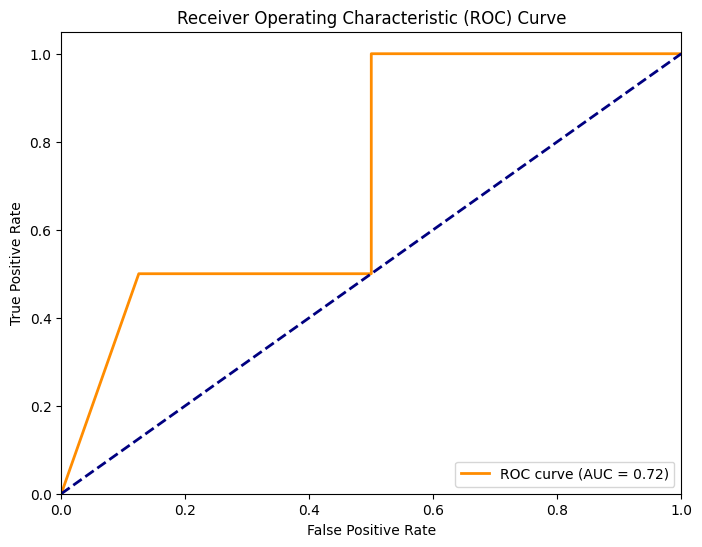

In [67]:
# Plot AUC curve in entirety
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [68]:
# Label the confusion matrix
# Pretty print the confusion matrix
class_names = ['Non-Interview', 'Interview']
print('Confusion Matrix')
print('-'*20)
print(f'{"":>10}{"Predicted Non-Interview":>15}{"Predicted Interview":>15}')
print(f'{"Actual Non-Interview":>10}{cm[0,0]:>15}{cm[0,1]:>15}')
print(f'{"Actual Interview":>10}{cm[1,0]:>15}{cm[1,1]:>15}')
print('-'*20)

Confusion Matrix
--------------------
          Predicted Non-InterviewPredicted Interview
Actual Non-Interview              3              5
Actual Interview              0              2
--------------------


# Actual Test Data

In [52]:
# Get test data
person_name = 'jeff bezos'
df = search_videos_advanced(person_name, 200, 50, 'long')
df.head(5)

,PublishedAt,ChannelId,Title,Description,Thumbnails,ChannelTitle,LiveBroadcastContent,PublishTime,VideoID,URL,Duration,ViewCount,LikeCount,DislikeCount,CommentCount
46,2024-03-24T15:10:00Z,UCEm_0Cv-bdGNSDiG55QJ0Yw,SCP-5821 Jeff Bezos Tastes Amazing! (Compilation),Join the DR BOB SQUAD by going to https://www....,https://i.ytimg.com/vi/KAk-6ayGlTs/default.jpg,Dr Bob,none,None,KAk-6ayGlTs,https://www.youtube.com/watch?v=KAk-6ayGlTs,232.73,64607,987,0,78
13,2021-08-20T17:51:30Z,UC6LEH0rS9V0BF5aNhVYdykQ,Bo Burnham vs. Jeff Bezos,COVID make man sad\n\nPatreon: https://www.pat...,https://i.ytimg.com/vi/UvYcunuF3Eo/default.jpg,CJ The X,none,None,UvYcunuF3Eo,https://www.youtube.com/watch?v=UvYcunuF3Eo,146.25,1458772,84847,0,8139
1,2023-12-14T17:53:21Z,UCSHZKyawb77ixDdsGog4iWA,Jeff Bezos: Amazon and Blue Origin | Lex Fridm...,Jeff Bezos is the founder of Amazon and Blue O...,https://i.ytimg.com/vi/DcWqzZ3I2cY/default.jpg,Lex Fridman,none,None,DcWqzZ3I2cY,https://www.youtube.com/watch?v=DcWqzZ3I2cY,131.53,4217231,94845,0,10422
26,2024-02-16T14:00:11Z,UCKmkpoEqg1sOMGEiIysP8Tw,Jeff Bezos' Advice if you're dreaming of success,✎ Get free access to our vault of PDF summarie...,https://i.ytimg.com/vi/Jx2Kzkj1iQE/default.jpg,Evan Carmichael,none,None,Jx2Kzkj1iQE,https://www.youtube.com/watch?v=Jx2Kzkj1iQE,115.48,6212,251,0,57
0,2020-02-19T02:00:04Z,UC3ScyryU9Oy9Wse3a8OAmYQ,Amazon Empire: The Rise and Reign of Jeff Bezo...,An inside look at how Amazon CEO Jeff Bezos bu...,https://i.ytimg.com/vi/RVVfJVj5z8s/default.jpg,FRONTLINE PBS | Official,none,None,RVVfJVj5z8s,https://www.youtube.com/watch?v=RVVfJVj5z8s,113.28,38704273,211982,0,28893


In [53]:
X_test_real = df['Description']
# Change text into numerical format
X_test_numerical_format = [get_text_features(text) for text in X_test_real]
# Predict on test data
predictions = model.predict_proba(X_test_numerical_format)[:, 1]
print(predictions)

df['predictions'] = predictions
df = df.sort_values('predictions', ascending=False)
df.head(5)
df.to_csv(f'{person_name}.csv', index=False)

[0.57492864 0.47008628 0.56481165 0.50586295 0.47297615 0.61066475
 0.60497769 0.46633572 0.31727026 0.44933241 0.31727026 0.31727026
 0.58400871 0.63709327 0.64744686 0.57571126 0.31727026 0.31727026
 0.60083282 0.38142403 0.31727026 0.62384168 0.46633572 0.56721231
 0.31727026 0.46418504 0.51884612 0.52604523 0.64744686 0.40081459
 0.31727026 0.31727026 0.31727026 0.17579863 0.2849457  0.64744686
 0.31727026 0.64744686 0.46136919 0.48773986 0.51003728 0.57571125
 0.5108082  0.55628414 0.53339196 0.48141293 0.50690593 0.64744686
 0.55179515 0.25429765]
